# Image Recognition with PCA - Lab

## Introduction

In this lab, you'll explore the classic MNIST dataset of handwritten digits. While not as large as the previous dataset on facial image recognition, it still provides a 64 dimensional dataset that is ripe for feature reduction.

## Objectives

You will be able to:
* Train a baseline classifier using sci-kit learn
* Use grid search to optimize the hyperparameters of a classifier
* Perform dimensionality reduction using PCA
* Calculate the time savings and performance gains of layering in PCA as a preprocessing step in machine learning pipelines

## Load the Data

To start, load the dataset using `sklearn.datasets.load_digits`.

In [1]:
from sklearn.datasets import load_digits

In [2]:
data = load_digits()
data

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

## Preview the Dataset

Now that the dataset is loaded, display the images of the first 20 pictures.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

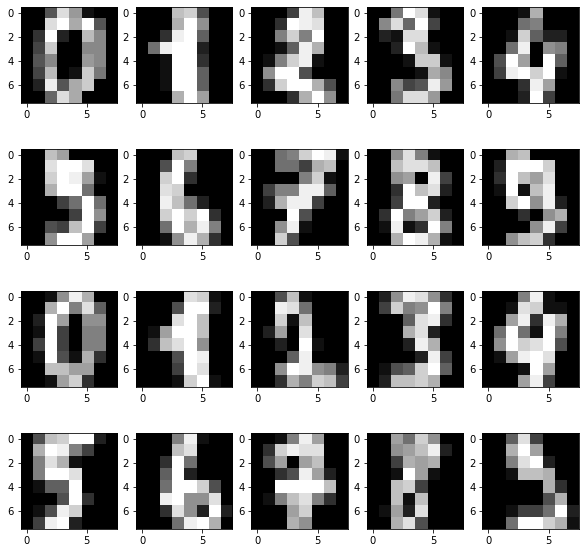

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
for n in range(20):
    i = n //5
    j = n%5
    ax = axes[i][j]
    ax.imshow(data.images[n], cmap=plt.cm.gray)

## Baseline Model

Now it's time to fit an initial baseline model to compare against. Fit a support vector machine to the dataset using `sklearn.sv.SVC()`. Be sure to perform a train test split, record the training time and print the training and testing accuracy of the model.

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [6]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [7]:
svc = SVC(gamma='auto')
%timeit svc.fit(X_train, y_train)

704 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
train_acc = svc.score(X_train, y_train)
test_acc = svc.score(X_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.3688888888888889


### Grid Search Baseline

Refine the initial model slightly by using a grid search to tune the hyperparameters. The two most important parameters to adjust are "C" and "gamma". Once again, be sure to record the training time as well as the train and test accuracy.

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {'C': np.linspace(.1,10,5),
             'gamma': np.linspace(10**-3,5,5)}
svc = SVC()
grid_s = GridSearchCV(svc, param_grid, cv=5)
%timeit grid_s.fit(X_train, y_train)

1min 21s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
train_acc = grid_s.best_estimator_.score(X_train, y_train)
test_acc = grid_s.best_estimator_.score(X_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9933333333333333


## Compressing with PCA

Now that you've fit a baseline classifier, it's time to explore the impacts of using PCA as a preprocessing technique. To start, perform PCA on X_train. (Be sure to only fit PCA to X_train; you don't want to leak any information from the test set.) Also, don't reduce the number of features quite yet. You'll determine the number of features needed to account for 95% of the overall variance momentarily.

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Plot the Explained Variance versus Number of Features

In order to determine the number of features you wish to reduce the dataset to, it is sensible to plot the overall variance accounted for by the first n principle components. Create a graph of the variance explained versus the number of principle components.

In [21]:
X[0].shape

(64,)

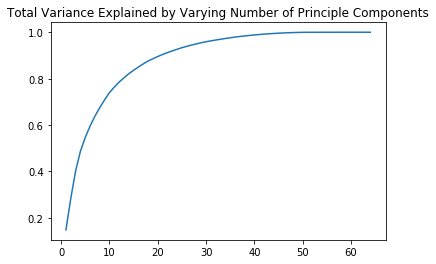

In [22]:
plt.plot(range(1,65), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

## Determine the Number of Features to Capture 95% of the Datasets Variance

Great! Now determine the number of features needed to capture 95% of the dataset's overall variance.

In [27]:
np.where(pca.explained_variance_ratio_.cumsum()>.95)

(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63], dtype=int64),)

## Subset the Dataset to these Principle Components which Capture 95%+ of the Overall Variance

Use your knowledge to reproject the dataset into a lower dimensional space using PCA. 

In [29]:
pca = PCA(n_components=28)
X_train_compressed = pca.fit_transform(X_train)

## Refit a Model on the Compressed Dataset

Now, refit a classification model to the compressed dataset. Be sure to time the required training time, as well as the test and training accuracy.

In [32]:
X_test_compressed = pca.transform(X_test)
clf = SVC(gamma='auto')
%timeit clf.fit(X_train_compressed, y_train)

415 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
train_pca_acc = clf.score(X_train_compressed, y_train)
test_pca_acc = clf.score(X_test_compressed, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_pca_acc, test_pca_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.12444444444444444


### Grid Search

Finally, use grid search to find optimal hyperparameters for the classifier on the reduced dataset. Be sure to record the time required to fit the model, the optimal hyperparameters and the test and train accuracy of the resulting model.

In [35]:
svc = SVC()
param_grid = {"C" : np.linspace(.1, 10, 5),
             "gamma" : np.linspace(10**-3, 5, 5)}
grid_search = GridSearchCV(svc, param_grid, cv=5)
%timeit grid_search.fit(X_train_compressed, y_train)

54.9 s ± 357 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
grid_search.best_params_

{'C': 2.575, 'gamma': 0.001}

In [37]:
train_acc = grid_search.best_estimator_.score(X_train_compressed, y_train)
test_acc = grid_search.best_estimator_.score(X_test_compressed, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9955555555555555


## Summary

Well done! In this lab, you employed PCA to reduce a high dimensional dataset. With this, you observed the potential cost benefits required to train a model and performance gains of the model itself.